# Examples on how to access prepared windows and features

### 0) Load packages and functions

In [1]:
# Importing Python and external packages
import os
import sys
import json
import importlib
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt


In [2]:
def get_project_path_in_notebook(
    subfolder=False,
):
    """
    Finds path of projectfolder from Notebook.
    Start running this once to correctly find
    other modules/functions
    """
    path = os.getcwd()

    while path[-20:] != 'dyskinesia_neurophys':

        path = os.path.dirname(path)
    
    if isinstance(subfolder, str):
        if os.path.exists(os.path.join(path,
                                       subfolder)):
            path = os.path.join(path, subfolder)
    
    return path

In [3]:
# define local storage directories
codepath = get_project_path_in_notebook('code')
print(codepath)
os.chdir(codepath)

# own functions
import utils.utils_fileManagement as utilsFiles
import lfpecog_analysis.ft_processing_helpers as ftProc
import lfpecog_analysis.load_SSD_features as load_ssdFts
from lfpecog_features.get_ssd_data import get_subject_SSDs
import lfpecog_predict.prepare_predict_arrays as prep_pred_arrs
import lfpecog_analysis.get_acc_task_derivs as accDerivs
import lfpecog_analysis.stats_fts_lid_corrs as ft_stats

c:\Users\tsbin\GitHub\dyskinesia_neurophys\code


### 0) Define settings

In [7]:
USER='jeroen'

# ft v6 (data v4.0) is most recent, WITHOUT TAP-MOVEMENT EXCLUSION
DATA_VERSION = 'v4.0'    # v4.0: new artef-rem, no reref; v3.0 multiple re-ref
FT_VERSION = 'v6'
# INCL_PSD_FTS=['mean_psd', 'variation']
IGNORE_PTS = ['011', '104', '106']  # aborted protocol, poor quality

CDRS_RATER = 'Jeroen'
ANALYSIS_SIDE = 'BILAT'
INCL_CORE_CDRS = True
CATEGORICAL_CDRS = False

MILD_CDRS = 4  # cut off for dyskinesia categorization
SEV_CDRS = 8  # cut off for dyskinesia categorization

In [8]:
importlib.reload(utilsFiles)

# get all available subs with features
SUBS = utilsFiles.get_avail_ssd_subs(DATA_VERSION=DATA_VERSION,
                                     FT_VERSION=FT_VERSION,
                                     IGNORE_PTS=IGNORE_PTS,
                                     USER=USER)
print(f'SUBS: n={len(SUBS)} ({SUBS})')  # should be 21


SUBS: n=21 (['107', '108', '019', '012', '110', '016', '109', '010', '017', '102', '101', '013', '103', '009', '014', '105', '020', '021', '023', '008', '022'])


## 1) Import neural features and clinical labels

- For predictions with ECoG-depending features: exclude moments of UNILATERAL dyskinesia IPSILATERAL to ECoG hemisphere

Get DataClass containing FEATS and CDRS-LABELS

In [ ]:
# # CREATE FeatureClass containing all features
# importlib.reload(utilsFiles)
# importlib.reload(accDerivs)
# importlib.reload(ftProc)
# importlib.reload(importClin)
# importlib.reload(load_ssdFts)
# importlib.reload(ftLidCorr)


# FT_VERSION = 'v6'
# INCL_CORE_CDRS = True
# CATEG_CDRS = False  # if False, full CDRS spectrum is used
# MILD_CDRS = 5  # cut off for dyskinesia categorization
# SEV_CDRS = 10  # cut off for dyskinesia categorization

# FeatLid = ftProc.FeatLidClass(
#     FT_VERSION=FT_VERSION,
#     INCL_ECOG=True,
#     INCL_ACC_RMS=True,
#     CATEGORICAL_CDRS=CATEG_CDRS,
#     CORR_TARGET='CDRS',  # target for correlation dataframe (not relevant)
#     cutMild=MILD_CDRS, cutSevere=SEV_CDRS,
#     TO_CALC_CORR=True,
# )


In [ ]:
# # SAVE FeatLabelClass as pickle

# featLabPath = os.path.join(utilsFiles.get_project_path('data'),
#                            'prediction_data',
#                            'featLabelClasses')
# className = f'featLabels_ft{FT_VERSION}'
# if FeatLid.CORR_TARGET == 'LID': className += '_Lid'
# elif FeatLid.CATEGORICAL_CDRS == True: className += '_CatCdrs'
# else: className += '_Cdrs'

# if FeatLid.INCL_ECOG: className += '_Ecog'
# else: className += '_StnOnly'

# utilsFiles.save_class_pickle(class_to_save=FeatLid,
#                              path=featLabPath,
#                              filename=className)

In [4]:
import utils.utils_fileManagement as utilsFiles

fpath = (
    "C:\\Users\\tsbin\\OneDrive - Charité - Universitätsmedizin Berlin\\"
    "PROJECT ECOG-LFP Coherence\\Jeroen_Dyskinesia\\data\\"
    "windowed_data_classes_10s_0.5overlap\\v4.0\\sub-008\\"
    "sub-008_windows_10s_v4.0_ecog_left.P"
)
data = utilsFiles.load_class_pickle(fpath)


... pickle loading: C:\Users\tsbin\OneDrive - Charité - Universitätsmedizin Berlin\PROJECT ECOG-LFP Coherence\Jeroen_Dyskinesia\data\windowed_data_classes_10s_0.5overlap\v4.0\sub-008\sub-008_windows_10s_v4.0_ecog_left.P


In [55]:
from mne.time_frequency import psd_array_multitaper

rawdata = np.array(data.data[:, :, np.arange(1, 7)].transpose(2, 0, 1), dtype=np.float64)
rawdata = np.reshape(rawdata, (rawdata.shape[0], rawdata.shape[1] * rawdata.shape[2]))
psd = psd_array_multitaper(rawdata[:, :20480], sfreq=data.fs, fmin=3, fmax=100)

    Using multitaper spectrum estimation with 7 DPSS windows


In [53]:
psd[0][0].shape

(1001,)

[[<matplotlib.lines.Line2D at 0x1c81a63e2a0>],

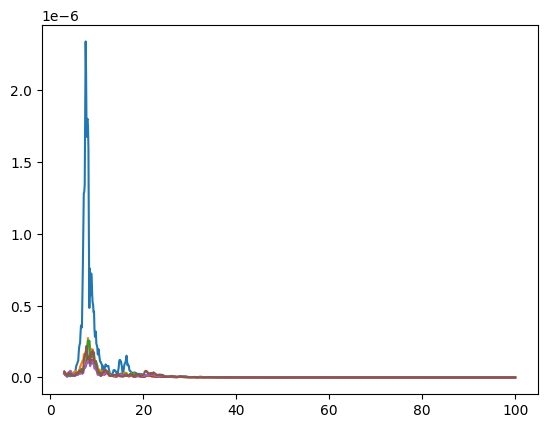

In [56]:
from matplotlib import pyplot as plt
[plt.plot(psd[1], psd[0][idx]) for idx in range(6)]

In [12]:
# LOAD existing classes with features and labels
INCL_ECOG = False  # if True, STN-only patients are NOT included
MILD_CDRS = 4  # cut off for dyskinesia categorization
SEV_CDRS = 8  # cut off for dyskinesia categorization

if INCL_ECOG: ecog_ext = '_Ecog'
else: ecog_ext = '_StnOnly'

# define path where pickle is saved
featLabPath = os.path.join(
    utilsFiles.get_project_path('data', USER=USER),
    'prediction_data', 'featLabelClasses'
)

predData = utilsFiles.load_class_pickle(
    os.path.join(featLabPath,
                 f'featLabels_ft{FT_VERSION}_'
                 f'Cdrs{ecog_ext}.P'),
    convert_float_np64=True
)
# MERGE GAMMA1-2-3 FEATURES
for sub in predData.FEATS:
    predData.FEATS[sub] = ft_stats.replace_gammas_for_maxGamma(predData.FEATS[sub])


... pickle loading: c:\Users\habetsj\Research\projects\dyskinesia_neurophys\data\prediction_data\featLabelClasses\featLabels_ftv6_Cdrs_StnOnly.P


#### Explore data

- Subject info
    - 0XX: subjects with ECoG
    - 1XX: subject WITHOUT ECoG

- Class info
    - stored in class FeatLidClass()
    - class definition in lfpecog_analysis.ft_processing_helpers
    - 

- FEATS: feature dict, sorted on subject
    - FEATS['022] contains dataframe with features per 10-sec window, 50% overlap
    - FEATS['022].index are timestamps for windows
    - FEATS['022].keys() are feature names
    -

- FT_LABELS: dyskinesia-label dict, sorted on subject
    - FEATS['022] contains array with dyskinesia labels, corresponding to FEATS
    - contains full CDRS scales
    - 

- ACC_RMS: mean (L + R) 10-sec (z-scored) root mean squares of vector magnitude of acc-data
    - FEATS['022] contains array with RMS values, corresponding to FEATS
    - average rms values are z-scored within every patient, movement cut off was -0.5 



In [57]:
# Class attributes
print(vars(predData).keys())

dict_keys(['FT_VERSION', 'CDRS_RATER', 'ANALYSIS_SIDE', 'INCL_STN', 'INCL_ECOG', 'EXCL_IPSI_ECOG', 'INCL_CORE_CDRS', 'INCL_PSD_FTS', 'INCL_ACC_RMS', 'IGNORE_PTS', 'CATEGORICAL_CDRS', 'cutMild', 'cutSevere', 'WIN_LEN_sec', 'WIN_OVERLAP_part', 'TO_CALC_CORR', 'CORR_TARGET', 'DATA_VERSION', 'SUBS', 'FEATS', 'FT_LABELS', 'ACC_RMS', 'corrs', 'stat_df'])


In [14]:
ex_sub = '022'
# FEATURE dict 
print(f'feat dict FEATS, sorted by patient:')
print(f'sub {ex_sub} FEATS df SHAPE: {predData.FEATS[ex_sub].shape}')
print(f'Window timestamps: {predData.FEATS[ex_sub].index[:5]}')
print(f'Feature names: {predData.FEATS[ex_sub].keys()[:5]}')
# predData.FEATS['022']  # dataframe with features, index = dopa_time in minutes



feat dict FEATS, sorted by patient:
sub 022 FEATS df SHAPE: (580, 28)
Window timestamps: Float64Index([-0.5833333333333334, -0.5, -0.4166666666666667,
              -0.3333333333333333, -0.25],
             dtype='float64')
Feature names: Index(['lfp_left_delta_mean_psd', 'lfp_left_delta_variation',
       'lfp_left_alpha_mean_psd', 'lfp_left_alpha_variation',
       'lfp_left_lo_beta_mean_psd'],
      dtype='object')


In [15]:
# Dyskinesia label dict
print(f'feat dict FT_LABELS, sorted by patient:')
print(predData.FT_LABELS.keys())
print(f'sub {ex_sub} FT_LABELS arr SHAPE: {predData.FT_LABELS[ex_sub].shape}')

orig_cdrs = predData.FT_LABELS[ex_sub].copy()

# to convert to categories
# categorized outcome:
# 0: none,
# 1: mild,
# 2: moderate,
# 3: severe
cat_cdrs = ftProc.categorical_CDRS(
    orig_cdrs, preLID_separate=False,
    preLID_minutes=0,
    cutoff_mildModerate=MILD_CDRS,
    cutoff_moderateSevere=SEV_CDRS
)


feat dict FT_LABELS, sorted by patient:
dict_keys(['012', '103', '016', '101', '019', '008', '013', '010', '110', '022', '107', '102', '109', '021', '017', '023', '009', '020', '014', '105', '108'])
sub 022 FT_LABELS arr SHAPE: (580,)


In [29]:
# RMS ACC movement dict  #### update jeroen
print(f'feat dict ACC_RMS, sorted by patient:')
print(predData.ACC_RMS.keys())
print(f'sub {ex_sub} FT_LABELS arr SHAPE: {predData.ACC_RMS[ex_sub].shape}')

rms_sub = predData.ACC_RMS[ex_sub].copy()



feat dict ACC_RMS, sorted by patient:
dict_keys(['012', '016', '019', '008', '013', '010', '022', '021', '017', '023', '009', '020', '014'])
sub 022 FT_LABELS arr SHAPE: (580,)


#### create prediction arrays based on imported features and labels

- creates:
    - X (features),
    - y (labels),
    - sub_ids.
- does not create:
    - parallel movement (RMS) yet (can be done parallel to y creation)

In [16]:
# Create arrays per subject based on features and labels
importlib.reload(prep_pred_arrs)

(X_total, y_total_binary,
 y_total_scale, sub_ids_total,
 ft_times_total, ft_names) = prep_pred_arrs.get_group_arrays_for_prediction(
    feat_dict=predData.FEATS,
    label_dict=predData.FT_LABELS,
    TO_PLOT = False)

# Merge subject-arrays to one group array for prediction
(X_all, y_all_binary,
 y_all_scale, sub_ids,
 ft_times_all) = prep_pred_arrs.merge_group_arrays(X_total=X_total,
                                    y_total_binary=y_total_binary,
                                    y_total_scale=y_total_scale,
                                    sub_ids_total=sub_ids_total,
                                    ft_times_total=ft_times_total)

# add categorical CDRS labels
y_all_categ = ftProc.categorical_CDRS(
    y_all_scale, preLID_separate=False,
    preLID_minutes=0,
    cutoff_mildModerate=MILD_CDRS,
    cutoff_moderateSevere=SEV_CDRS
)

print(f'Subjects (n={len(np.unique(sub_ids))}) included: {np.unique(sub_ids)}')

	for sub-012, added X-shape: (803, 28)
	for sub-103, added X-shape: (650, 28)
	for sub-016, added X-shape: (679, 28)
	for sub-101, added X-shape: (705, 28)
	for sub-019, added X-shape: (927, 28)
	for sub-008, added X-shape: (545, 28)
	for sub-013, added X-shape: (659, 28)
	for sub-010, added X-shape: (670, 28)
	for sub-110, added X-shape: (700, 28)
	for sub-022, added X-shape: (580, 28)
	for sub-107, added X-shape: (779, 28)
	for sub-102, added X-shape: (676, 28)
	for sub-109, added X-shape: (545, 28)
	for sub-021, added X-shape: (526, 28)
	for sub-017, added X-shape: (549, 28)
	for sub-023, added X-shape: (549, 28)
	for sub-009, added X-shape: (768, 28)
	for sub-020, added X-shape: (420, 28)
	for sub-014, added X-shape: (519, 28)
	for sub-105, added X-shape: (629, 28)
	for sub-108, added X-shape: (539, 28)
012 803
removed rows n=148
(13269, 28) (13269,) (13269,) (13269,) (13269,)
out of n=13269 samples, n=6806 are Dyskinesia (51.3 %)
Subjects (n=21) included: ['008' '009' '010' '012' 

## 2) Import epoched raw- or SSDed-data



#### A) SSD import

- SSD Class info
    - stored in class get_subject_SSDs(), (defined in lfpecog_features.get_ssd_data)
    - contains lfp_left, lfp_right (ecog_right/ecog_left): class SSD_bands_windowed()

    - lfp_left, lfp_right, ecog_right
        - stored in class SSD_bands_windowed(), (defined in lfpecog_features.get_ssd_data)
        - contains:
            - times: list of start-window times for all timeseries-array rows
            - fs (Hz)
            - settings (dict) with all extraction settings
            - delta (IS THETA!!)
            - alpha
            - lo_beta
            - hi_beta
            - gamma1
            - gamma2
            - gamma3

    - e.g. lo_beta is array with timeseries: windows x samples (720, 20480)

In [17]:
import lfpecog_features.get_ssd_data as ssd
import lfpecog_analysis.get_SSD_timefreqs as ssd_TimeFreq
import lfpecog_plotting.plot_timeFreqs_ssd_psds as plot_ssd_TFs

In [19]:
importlib.reload(ssd)

ex_sub = '022'
# import dataclass containing SSD data

ssdSub = ssd.get_subject_SSDs(sub=ex_sub,
                             incl_stn=True,
                             incl_ecog=True,
                             ft_setting_fname=f'ftExtr_spectral_{FT_VERSION}.json',
                             USER=USER,)


loop loop
...loading windowed ssd c:\Users\habetsj\Research\projects\dyskinesia_neurophys\data\windowed_data_classes_10s_0.5overlap\v4.0\sub-022\broadSSD_windowedBands_022_ecog_right_v6.json c:\Users\habetsj\Research\projects\dyskinesia_neurophys\data\windowed_data_classes_10s_0.5overlap\v4.0\sub-022\broadSSD_windowedBands_022_ecog_right_v6.npy
	...loaded SSD windowed-data and meta-info for ecog_right of sub-022
...loading windowed ssd c:\Users\habetsj\Research\projects\dyskinesia_neurophys\data\windowed_data_classes_10s_0.5overlap\v4.0\sub-022\broadSSD_windowedBands_022_lfp_left_v6.json c:\Users\habetsj\Research\projects\dyskinesia_neurophys\data\windowed_data_classes_10s_0.5overlap\v4.0\sub-022\broadSSD_windowedBands_022_lfp_left_v6.npy
	...loaded SSD windowed-data and meta-info for lfp_left of sub-022
...loading windowed ssd c:\Users\habetsj\Research\projects\dyskinesia_neurophys\data\windowed_data_classes_10s_0.5overlap\v4.0\sub-022\broadSSD_windowedBands_022_lfp_right_v6.json c:\U

In [33]:
print(f'length of timestamps: {np.array(ssdSub.ecog_right.times).shape}')
print(f'shape of ALPHA timeseries (windows x samples): {ssdSub.ecog_right.alpha.shape}')
# settings contains (dict) all feature extraction settings
print(f'sampling freq: {ssdSub.ecog_right.fs}, window length: '
      f'{ssdSub.ecog_right.settings["WIN_LEN_sec"]} sec')

length of timestamps: (720,)
shape of ALPHA timeseries (windows x samples): (720, 20480)
sampling freq: 2048, window length: 10 sec



#### B) Raw windows import

- windowed Class info
    - stores ONE DATATYPE (LFP L/R / ECOG), for ONE subject
    - stored in class windowedData(), (defined in utils.utils_windowing)
    - contains:
        - data: array, 3-dimens.: n-windows, n-samples, n-channels
            NOTE: WINDOWS CAN STILL CONTAIN NANs
        - fs: int
        - keys: list (n-channels), contains dopa_time, ephys-channels,
            task, and movement derivatives
        - win_starttimes: list of winstart-times IN SECONDS (dopa_time)
        

In [37]:
importlib.reload(utilsFiles)

USER = 'timon'
FT_VERSION = 'v6'

# load ft extraction settings
SETTINGS = utilsFiles.load_ft_ext_cfg(FT_VERSION=FT_VERSION,
                                      USER=USER)

# get available subs
SUBS = SETTINGS['TOTAL_SUBS']

# define 
ephys_sources = ['lfp_right', 'lfp_left', 'ecog_left', 'ecog_right']
use_stored_windows = True

sub = '108'


windows_path = os.path.join(
    utilsFiles.get_project_path('data', USER=USER),
    'windowed_data_classes_'
    f'{SETTINGS["WIN_LEN_sec"]}s_'
    f'{SETTINGS["WIN_OVERLAP_part"]}overlap',
    SETTINGS['DATA_VERSION'],
    f'sub-{sub}')

FileNotFoundError: [Errno 2] No such file or directory: 'D:\\\\dyskinesia_project\\\\data\\meta_info\\ftExtr_spectral_v6.json'

In [66]:
windows = {}
for dType in ephys_sources:
    print(f'\tstart {dType}')
    # define path for windows of dType
    dType_fname = (f'sub-{sub}_windows_'
                   f'{SETTINGS["WIN_LEN_sec"]}s_'
                   f'{SETTINGS["DATA_VERSION"]}_{dType}.P')
    dType_win_path = os.path.join(windows_path, dType_fname)

    # check if windows are already available
    if np.logical_and(use_stored_windows,
                      os.path.exists(dType_win_path)):
        print(f'load data from {windows_path}....')
        wins = utilsFiles.load_class_pickle(dType_win_path)
        print(f'\tWINDOWS LOADED from {dType_fname} in {windows_path}')

        # add to dict
        windows[dType] = wins
    else:
        print(f'data not found for sub-{sub}, {dType}')

	start ecog_left
data not found for sub-108, ecog_left
	start ecog_right
data not found for sub-108, ecog_right


In [69]:
# example
print(f'data shape: {wins.data.shape} (sfreq: {wins.fs} Hz)')
print(f'corresponding times of window start: {len(wins.win_starttimes)}')
print(f'corresponding channel keys: {len(wins.keys)}')

data shape: (539, 20480, 15) (sfreq: 2048 Hz)
corresponding times of window start: 539
corresponding channel keys: 15
